<a href="https://colab.research.google.com/github/Aakaey181/RA_Porject_ML1/blob/main/CleanFinalModelForZebraCrossing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction <br>
In this module, we will walk through an end-to-end project to build a binary classifier that detects the presence of zebra crossings in road images. Inspired by the Analytics Vidhya tutorial, our workflow covers the following steps: <br>

*   Data collection using web scraping (DuckDuckGo API) (OPT)
*   Data organization and preprocessing
*   Model building and transfer learning (using MobileNetV2 pre-trained on ImageNet)
*   Cross-validation using StratifiedShuffleSplit
*   Model evaluation, including F1 Score calculation

Vidhya tutorial link: https://medium.com/analytics-vidhya/how-to-train-a-neural-network-classifier-on-imagenet-using-tensorflow-2-ede0ea3a35ff


---



# 2. Environment Setup and Data Collection



Code Operations:
- Mounting Google Drive: <br>
We import necessary libraries and mount Google Drive to access data stored there.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Importing Libraries: <br>
We import libraries such as requests, os, shutil, random, and TensorFlow/Keras components.

In [17]:
import os
import requests
import time
import shutil
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2

Image Downloading: <br>
We begin by collecting images for both classes:

Positive class: Images with zebra crossings

Negative class: Images without zebra crossings (e.g., roads, highways, etc.)

A custom web-scraping script using the DuckDuckGo API downloads images and saves them to our Google Drive. Negative samples from various road-related queries are merged into a unified folder (road_without_zebra_crossing).

In [18]:
# Base directory (where images will be saved)
BASE_DATA_DIR = "drive/MyDrive/ra/data"
RAW_IMAGE_DIR = os.path.join(BASE_DATA_DIR, "raw_images")
os.makedirs(RAW_IMAGE_DIR, exist_ok=True)

Gather All Images + Labels from RAW_IMAGE_DIR

In [19]:
class_names = sorted(os.listdir(RAW_IMAGE_DIR))
print("Classes found in RAW_IMAGE_DIR:", class_names)

file_paths = []
labels = []
for idx, cls_name in enumerate(class_names):
    cls_folder = os.path.join(RAW_IMAGE_DIR, cls_name)
    if not os.path.isdir(cls_folder):
        continue
    # 0 or 1 label
    for f in os.listdir(cls_folder):
        file_paths.append(os.path.join(cls_folder, f))
        labels.append(idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

print("Total images:", len(file_paths))

Classes found in RAW_IMAGE_DIR: ['road_without_zebra_crossing', 'zebra_crossing']
Total images: 870


Filter Invalid Images (if desired)

In [20]:
valid_exts = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

def is_valid_image(path):
    ext = os.path.splitext(path)[1].lower()
    return ext in valid_exts

valid_indices = []
for i, path in enumerate(file_paths):
    if is_valid_image(path):
        valid_indices.append(i)

file_paths = file_paths[valid_indices]
labels = labels[valid_indices]

print("After filtering invalid extensions:", len(file_paths))

After filtering invalid extensions: 870


In [21]:
# check & remove corrupted files
def check_corrupt(path):
    try:
        data = tf.io.read_file(path)
        _ = tf.image.decode_jpeg(data, channels=3)
        return True
    except Exception as e:
        print(f"Corrupted file removed: {path} - Error: {e}")
        os.remove(path)
        return False

final_paths = []
final_labels = []
for p, l in zip(file_paths, labels):
    if check_corrupt(p):
        final_paths.append(p)
        final_labels.append(l)

file_paths = np.array(final_paths)
labels = np.array(final_labels)
print("After removing corrupted files:", len(file_paths))


After removing corrupted files: 870


Define Preprocessing + Create Dataset Function

In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = mobilenet_v2.preprocess_input(img)
    return img, label

def create_dataset(paths, labs):
    ds = tf.data.Dataset.from_tensor_slices((paths, labs))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

Task 2: StratifiedShuffleSplit for Cross Validation

In [23]:
# Step 1: Define a Function to Build the Model
def build_model():
    """
    Builds and compiles a binary classification model using MobileNetV2 as the base.
    """
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # Output probability for binary classification
    ])
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [24]:
# Step 2: Set Up StratifiedShuffleSplit for Cross Validation

n_splits = 5
test_size = 0.2  # 80% training, 20% validation for each split
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

print("Total images for cross validation:", len(file_paths))

# Step 3: Cross Validation Loop - Train and Evaluate the Model for Each Fold
fold = 1
fold_accs = []
fold_losses = []

for train_idx, val_idx in sss.split(file_paths, labels):
    print(f"\n===== Fold {fold} =====")
    # Split file paths and labels into training and validation sets for this fold
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create tf.data.Datasets using your pre-defined create_dataset function
    train_ds = create_dataset(train_paths, train_labels)
    val_ds = create_dataset(val_paths, val_labels)

    # Build a fresh model for this fold
    model = build_model()
    model.summary()

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10) #defaut epochs = 10

    # Evaluate on the validation set
    loss, acc = model.evaluate(val_ds)
    print(f"Fold {fold} - Validation Accuracy: {acc:.2f}, Loss: {loss:.4f}")
    fold_accs.append(acc)
    fold_losses.append(loss)

    fold += 1

# Calculate and print average performance metrics across all folds
avg_acc = np.mean(fold_accs)
avg_loss = np.mean(fold_losses)
print(f"\nAverage Validation Accuracy over {n_splits} folds: {avg_acc:.2f}")
print(f"Average Validation Loss over {n_splits} folds: {avg_loss:.4f}")

Total images for cross validation: 870

===== Fold 1 =====


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7497 - loss: 0.5105 - val_accuracy: 0.9713 - val_loss: 0.0832
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9665 - loss: 0.0943 - val_accuracy: 0.9770 - val_loss: 0.0864
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9730 - loss: 0.0640 - val_accuracy: 0.9770 - val_loss: 0.0881
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9843 - loss: 0.0453 - val_accuracy: 0.9828 - val_loss: 0.0870
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9775 - loss: 0.0470 - val_accuracy: 0.9828 - val_loss: 0.0863
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9953 - loss: 0.0229 - val_accuracy: 0.9770 - val_loss: 0.0840
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9918 - loss: 0.0214 - val_accuracy: 0.9770 - val_loss: 0.0847
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9942 - loss: 0.0218 - val_accuracy: 0.9828 - val_loss:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7362 - loss: 0.5695 - val_accuracy: 0.9425 - val_loss: 0.1368
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9622 - loss: 0.1091 - val_accuracy: 0.9483 - val_loss: 0.1211
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9680 - loss: 0.0747 - val_accuracy: 0.9483 - val_loss: 0.1197
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9791 - loss: 0.0631 - val_accuracy: 0.9483 - val_loss: 0.1319
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9936 - loss: 0.0324 - val_accuracy: 0.9483 - val_loss: 0.1481
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9894 - loss: 0.0306 - val_accuracy: 0.9425 - val_loss: 0.1825
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9899 - loss: 0.0434 - val_accuracy: 0.9598 - val_loss: 0.1033
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9957 - loss: 0.0175 - val_accuracy: 0.9770 - val_loss:

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7646 - loss: 0.4849 - val_accuracy: 0.9655 - val_loss: 0.1108
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9635 - loss: 0.1053 - val_accuracy: 0.9770 - val_loss: 0.0990
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9705 - loss: 0.0662 - val_accuracy: 0.9713 - val_loss: 0.0987
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9851 - loss: 0.0476 - val_accuracy: 0.9655 - val_loss: 0.1010
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9811 - loss: 0.0537 - val_accuracy: 0.9713 - val_loss: 0.1021
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9872 - loss: 0.0351 - val_accuracy: 0.9655 - val_loss: 0.1091
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.9983 - loss: 0.0168 - val_accuracy: 0.9598 - val_loss: 0.1270
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9991 - loss: 0.0191 - val_accuracy: 0.9713 - val_loss:

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7881 - loss: 0.4449 - val_accuracy: 0.9540 - val_loss: 0.1236
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9679 - loss: 0.0846 - val_accuracy: 0.9713 - val_loss: 0.1043
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9784 - loss: 0.0564 - val_accuracy: 0.9483 - val_loss: 0.1136
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9785 - loss: 0.0506 - val_accuracy: 0.9425 - val_loss: 0.1157
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9935 - loss: 0.0308 - val_accuracy: 0.9310 - val_loss: 0.1463
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9772 - loss: 0.0508 - val_accuracy: 0.9598 - val_loss: 0.1133
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9598 - val_loss: 0.0947
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9655 - val_loss:

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7747 - loss: 0.5097 - val_accuracy: 0.9310 - val_loss: 0.1968
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9437 - loss: 0.1696 - val_accuracy: 0.9483 - val_loss: 0.1367
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9682 - loss: 0.0853 - val_accuracy: 0.9483 - val_loss: 0.1151
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9760 - loss: 0.0562 - val_accuracy: 0.9540 - val_loss: 0.0985
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9825 - loss: 0.0395 - val_accuracy: 0.9540 - val_loss: 0.0967
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9900 - loss: 0.0332 - val_accuracy: 0.9540 - val_loss: 0.1095
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9919 - loss: 0.0260 - val_accuracy: 0.9540 - val_loss: 0.1266
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9958 - loss: 0.0213 - val_accuracy: 0.9598 - val_loss:

# Model Evaluation (F1 Score and Interactive Prediction)

In [25]:
# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9699 - loss: 0.0875
Test Accuracy: 0.97
Test Loss: 0.0906


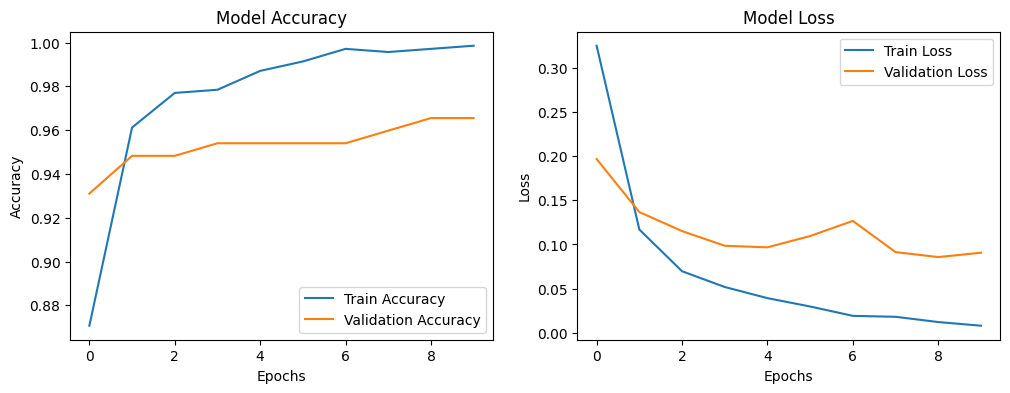

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

In [27]:
from sklearn.metrics import f1_score

val_preds = []
val_trues = []
for images, labs in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).squeeze()
    val_preds.extend(preds.tolist())
    val_trues.extend(labs.numpy().tolist())

f1 = f1_score(val_trues, val_preds)
print("F1 Score for last fold's val set:", f1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
F1 Score for last fold's val set: 0.96


In [28]:
model.save("drive/MyDrive/ra/trained_models/clean_mobilenet_binary_classifier.h5")
print("model saved: clean_mobilenet_binary_classifier.h5")

model saved: clean_mobilenet_binary_classifier.h5


In [29]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model (if not already loaded)
model = tf.keras.models.load_model("drive/MyDrive/ra/trained_models/clean_mobilenet_binary_classifier.h5")

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    probability = model.predict(img_array)[0][0]
    confidence = probability * 100
    print(f"Prediction: {confidence:.2f}% confidence that the target object is present.")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {confidence:.2f}% Confidence")
    plt.show()

In [30]:
# To test, allow user to upload an image:
from google.colab import files
uploaded = files.upload()
if uploaded:
    test_img_path = list(uploaded.keys())[0]
    predict_image(test_img_path)